In [1]:
import numpy as np
import os
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt

print("Hello world.")

2025-09-24 10:21:35.391506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758709295.739388      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758709295.835629      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Hello world.


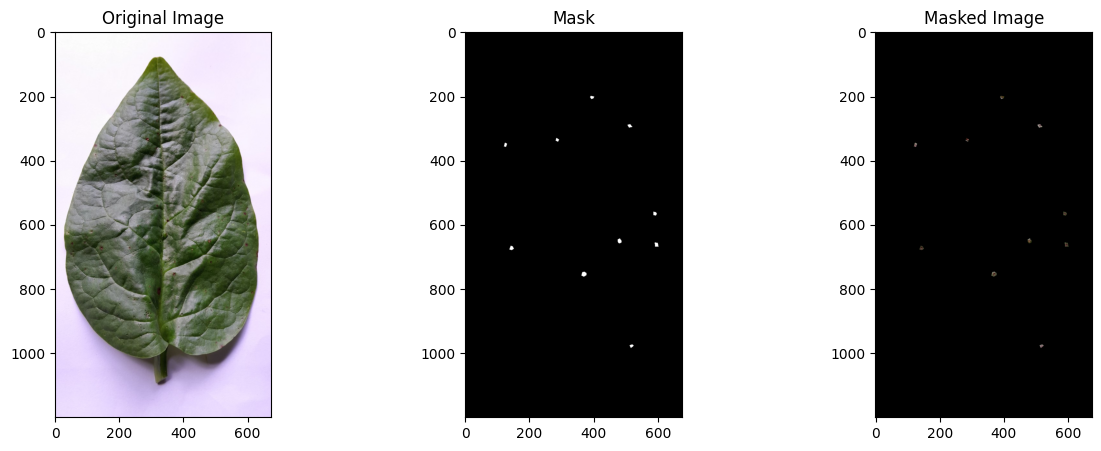

In [2]:


image_path = r"/kaggle/input/malabar-dataset/Malabar_Dataset/Bacterial-Spot(752)/Bacterial-Spot (1).jpg"
image = cv2.imread(image_path)

json_path = r"/kaggle/input/temp-dataset/annotated_json_files/Bacterial-Spot(752)/affected_region/Bacterial-Spot (1).json"
with open(json_path, 'r') as file:
    data = json.load(file)

# Create a blank mask with the same dimensions as the input image
mask = np.zeros(image.shape[:2], dtype=np.uint8)

if 'shapes' in data:
    for annotation in data['shapes']:
        points = np.array(annotation['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], color=255)
elif 'annotations' in data:
    for annotation in data['annotations']:
        points = np.array(annotation['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], color=255)
else:
    print("No valid keys ('shapes' or 'annotations') found in JSON.")

# Apply the mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Display the original image, mask, and masked image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Masked Image")
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.show()

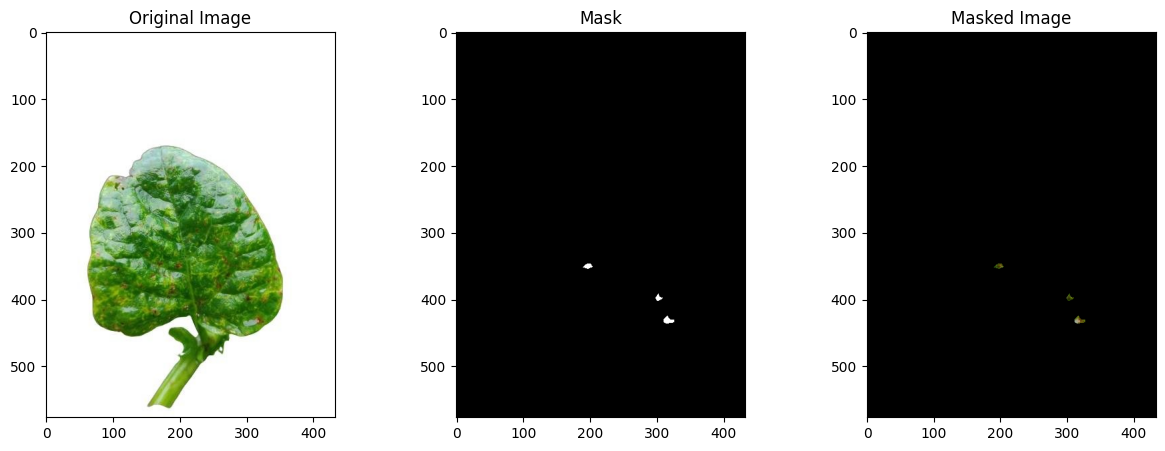

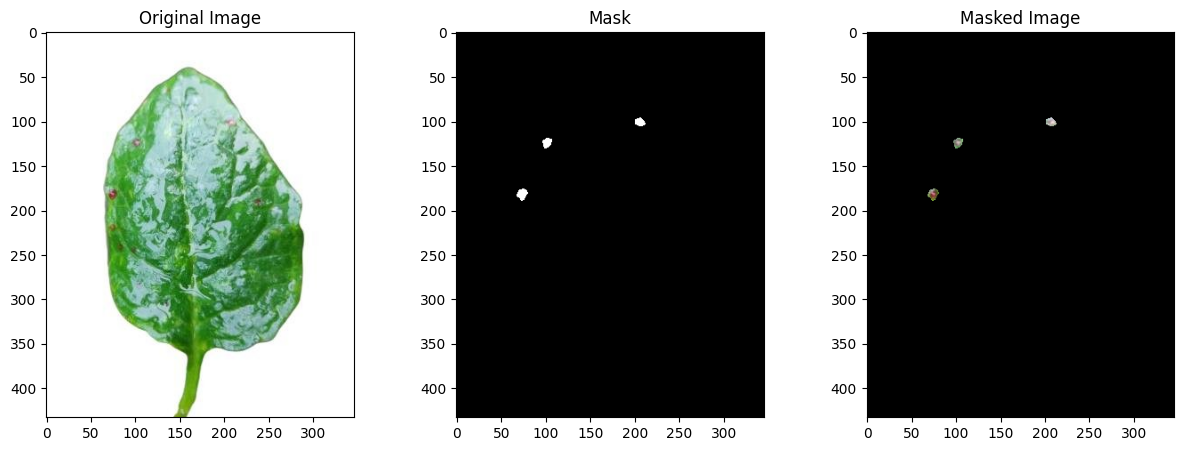

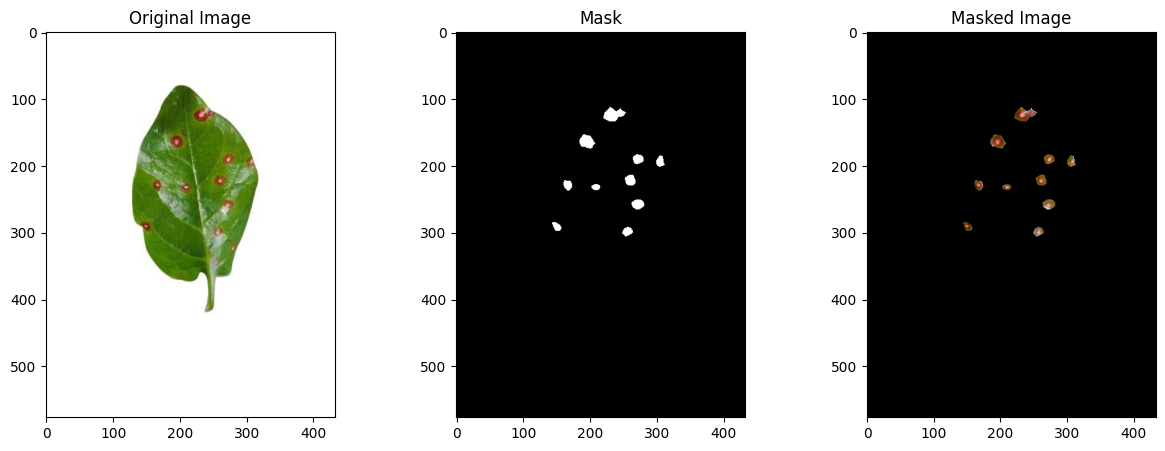

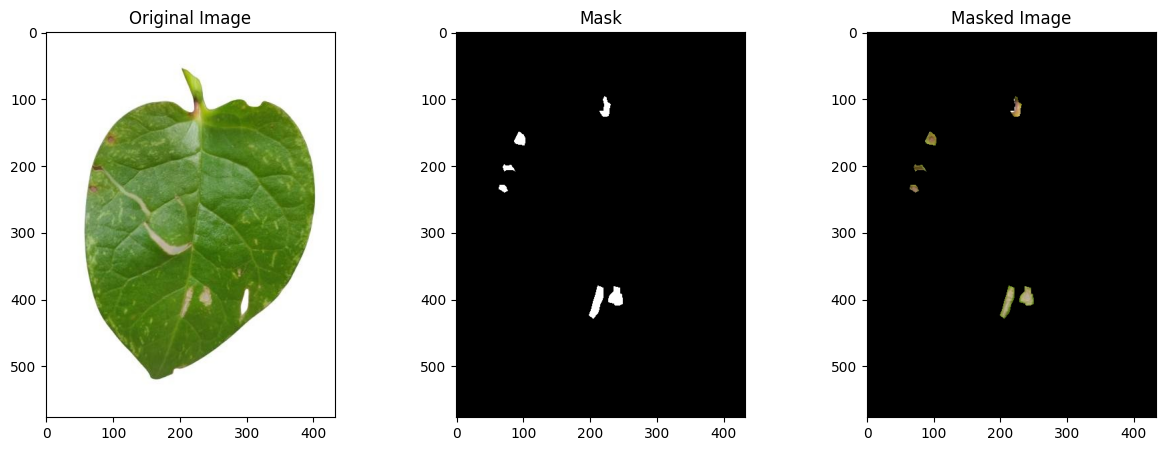

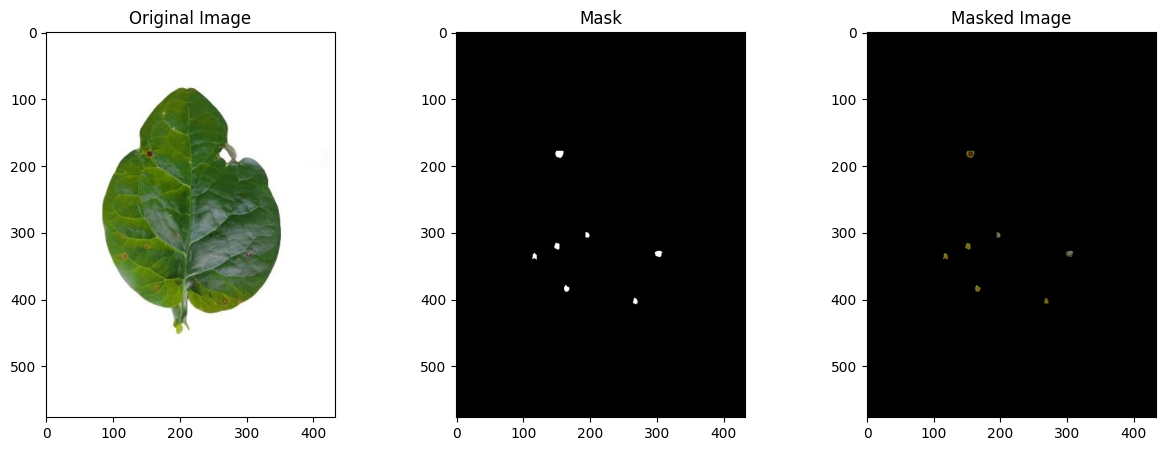

In [3]:
i = 0 
image_path = "/kaggle/input/malabar-dataset/Malabar_Dataset/Bacterial-Spot(752)"
json_path = "/kaggle/input/temp-dataset/annotated_json_files/Bacterial-Spot(752)/affected_region"
for i in range(45, 50):
    image_name = "Bacterial-Spot ("+str(i+1)+").jpg"
    json_file_name = "Bacterial-Spot ("+str(i+1)+").json"
    #print(image_name)
    #print(json_file_name)
    image = cv2.imread(image_path+'/'+image_name)
    json_file = json_path + '/' + json_file_name
    #print(json_file)

    with open(json_file, 'r') as file:
        data = json.load(file)

    # Create a blank mask with the same dimensions as the input image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    if 'shapes' in data:
        for annotation in data['shapes']:
            points = np.array(annotation['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=255)
    elif 'annotations' in data:
        for annotation in data['annotations']:
            points = np.array(annotation['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], color=255)
    else:
        print("No valid keys ('shapes' or 'annotations') found in JSON.")

    masked_image = cv2.bitwise_and(image, image, mask=mask)


    # Display the original image, mask, and masked image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Masked Image")
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

    plt.show()




In [4]:
def create_mask(json_file, image_shape):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    for shape in data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    
    return mask


train_images, valid_images, test_images = [], [], []
train_masks, valid_masks, test_masks = [], [], []

for i in range(0, 50):

    json_file_name = "Bacterial-Spot ("+str(i+1)+").json"
    json_file = json_path + '/' + json_file_name
    
    image_name = "Bacterial-Spot ("+str(i+1)+").jpg"
    image = cv2.imread(image_path+'/'+image_name)
    if image is None:
        continue
    
    mask = create_mask(json_file, image.shape)
    
    # Save mask
    #mask_path = os.path.join(mask_dir, f'mask_{i+1}.png')
    #cv2.imwrite(mask_path, mask)
    
    if i < 40:
        train_images.append(image)
        train_masks.append(mask)
    elif i < 45:
        valid_images.append(image)
        valid_masks.append(mask)
    else:
        test_images.append(image)
        test_masks.append(mask)


print("Hello world.")

Hello world.


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

def build_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unet_model = build_unet()
unet_model.summary()

I0000 00:00:1758709317.249934      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758709317.251051      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Preprocess images and masks
image_size = (256, 256)

def preprocess_data(images, masks):
    images_resized = [cv2.resize(img, image_size) for img in images]
    masks_resized = [cv2.resize(mask, image_size) for mask in masks]
    
    images_array = np.array(images_resized) / 255.0
    masks_array = np.array(masks_resized) / 255.0
    
    images_array = images_array.astype(np.float32)
    masks_array = masks_array.astype(np.float32)
    
    masks_array = np.expand_dims(masks_array, axis=-1)  # Ensure correct shape
    
    return images_array, masks_array

# Prepare datasets
X_train, y_train = preprocess_data(train_images, train_masks)
X_valid, y_valid = preprocess_data(valid_images, valid_masks)
X_test, y_test = preprocess_data(test_images, test_masks)

# Callbacks
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)

# Train the model
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate on test set
test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50


I0000 00:00:1758709323.930577     106 service.cc:148] XLA service 0x79ec9c848d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758709323.932313     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758709323.932362     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758709324.583699     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-24 10:22:09.195566: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[8,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_s

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5425 - loss: 0.5105
Epoch 1: val_loss improved from inf to 0.37347, saving model to unet_best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5850 - loss: 0.4784 - val_accuracy: 0.9937 - val_loss: 0.3735
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9968 - loss: 0.1237
Epoch 2: val_loss improved from 0.37347 to 0.05426, saving model to unet_best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.9968 - loss: 0.1185 - val_accuracy: 0.9937 - val_loss: 0.0543
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9966 - loss: 0.0563
Epoch 3: val_loss did not improve from 0.05426
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.9966 - loss: 0.0544 - val_accuracy: 0.9937 - val_loss: 0.0556
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9961 - loss: 0.0371
Epoch 4: val_loss did not improve from 0.05426
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.9962 - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


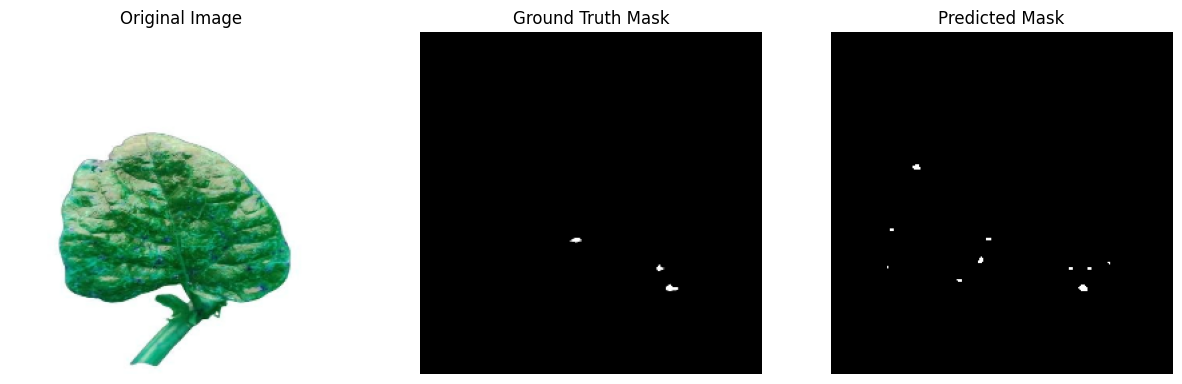

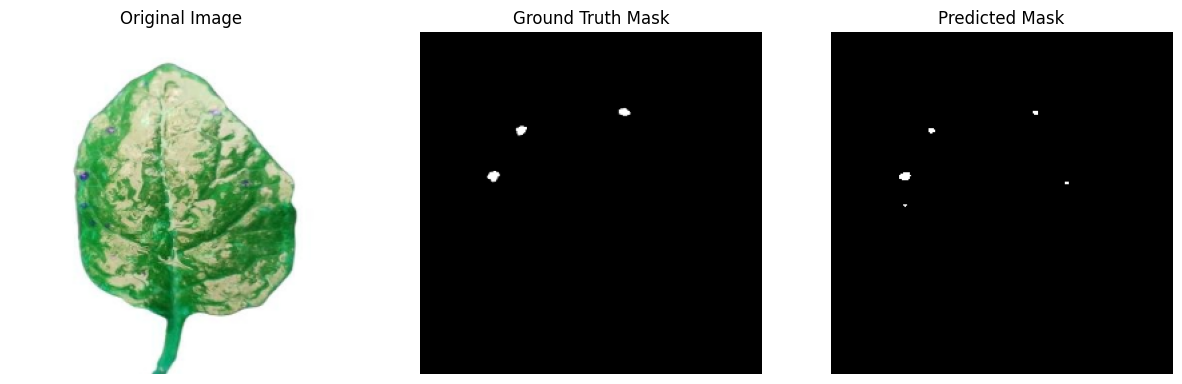

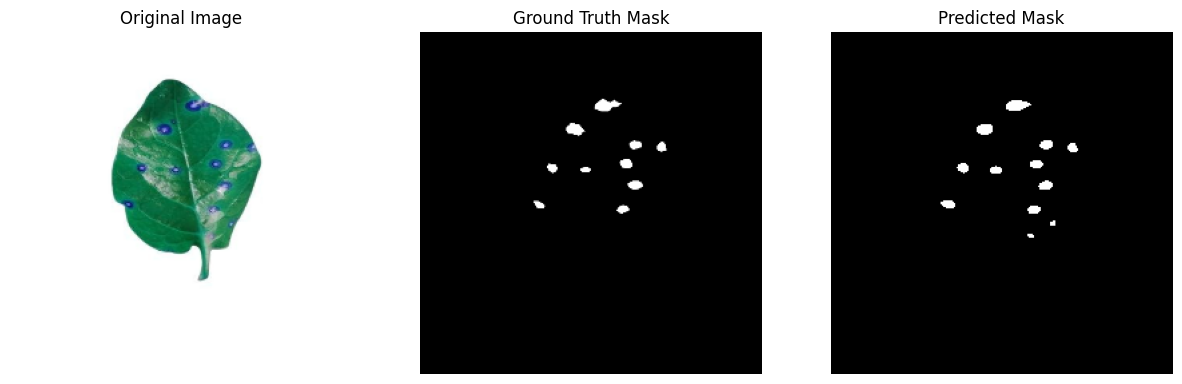

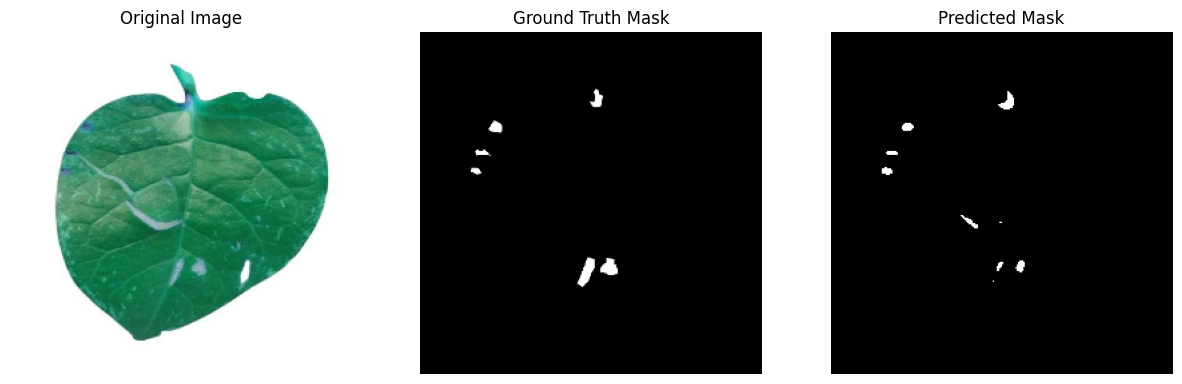

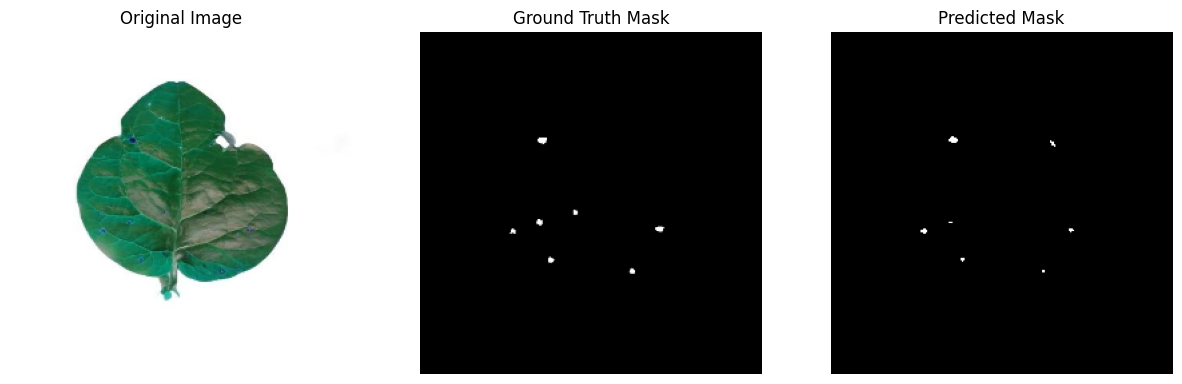

In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Make predictions on the test set
predictions = unet_model.predict(X_test)

# Create masks from the predictions
predicted_masks = create_mask(predictions)

# Function to visualize the results
def visualize_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        # Original image
        img = images[i]
        # Ground truth mask
        true_mask = masks[i]
        # Predicted mask
        predicted_mask = predictions[i]
        
        # Plotting
        plt.figure(figsize=(15, 5))
        
        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

# Visualizing the results
visualize_results(X_test, y_test, predicted_masks, num_images=5)

# Optionally, you can save some of the predicted masks for further analysis
def save_predicted_masks(predictions, output_dir="predicted_masks"):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for i, pred in enumerate(predictions):
        mask_path = os.path.join(output_dir, f"pred_mask_{i}.png")
        cv2.imwrite(mask_path, (pred.squeeze() * 255).astype(np.uint8))  # Save as binary image

# Save the predicted masks
save_predicted_masks(predicted_masks)